#### Basic setup

### Document extraction

This notebook's purpose is to make an in-depth exploration on the best ways to extract information regarding OpenCV. During the first exploratory notebook, documents were extracted from OpenCV's documentation using a recursive URL loader. One of the main challenges of this RAG is to make information Python-specific, which might be difficult given that OpenCV is written in C++, with `opencv-python` being the library available as a wrapper with bindings for Python. Most of the solutions to overcome this challenge may come in the preprocessing and prompt engineering sections of this RAG, but an exploratory task is done during this extraction phase in order to include relevant metadata that may ignore C++-centric code and documentation. Taking this issue into account, in addition to the initial exploration made in the [ExploringOpenCV](/../Notebooks/ExploringOpenCV.ipynb) notebook, this notebook has the following goals:

1. [Further explore the best way to extract information from OpenCV's documentation](#explore-documentation)
    1. Explore different values for the most relevant `RecursiveUrlLoader`'s parameters. Analyze document number vs extraction velocity.
    2. Record and analyze failed or slow requests, to better refine parameters in `RecursiveUrlLoader`. 
2. [Find new sources for information regarding OpenCV's features](#new-sources)
    1. Extract information from [LearnOpenCV](https://learnopencv.com). Specially, from its [Getting Started with OpenCV](https://learnopencv.com/getting-started-with-opencv/) guide. In this case, `RecursiveUrlLoader` might not be the best idea. Instead, an initial approach will be to have a tutorial list for each guide, which is easily accessible.
    
    2. Explore the usefulness of including [FreeCodeCamp's OpenCV Course](https://www.youtube.com/watch?v=oXlwWbU8l2o) as part of the knowledge base. This would require a transcript of the video, which might be computationally expensive and there's risk of inaccuracies.
3. [Create a relevance measurement](#relevance-measurement)

    This tool would compare each document's title and summary to a base document (to be defined) and flag possible irrelevant documents. This step is important for two main concerns regarding data extraction:
    
    - `RecursiveUrlLoader` may extract documents that are not relevant to a person looking for documentation, such as a contact page.
    - Some documents might be too C++-oriented, such as the use of CMake to install OpenCV. These should be discarded.


Let's start by setting up relevant environment variables. In this particular case, it is important to set `USER_AGENT` while web scrapping in order to avoid being blocked during extraction.

In [4]:
from dotenv import load_dotenv
import os
load_dotenv()
user_agent = os.getenv("USER_AGENT", "DefaultUserAgent")
print(user_agent)

Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:132.0) Gecko/20100101 Firefox/132.0


#### Exploring how to extract information from OpenCV's documentation <a class="anchor" id="explore-documentation"></a>

First, we will focus on exploring the most relevant parameters of `RecursiveUrlLoader`. Besides the `url`, `extractor` and `prevent_outside`, which will not be changed for the purpose of this exploration, we will focus on two parameters that are going to be changed:
- `max_depth`
- `timeout`

We will also register the logs of the extraction process to identify extraction time, document count and possible errors. First, we set up needed imports, logging and parameters to be adjusted, in addition to the `BeautifulSoup` extractor used, which makes the extracted documents human- and LLM-friendly.

In [ ]:
import logging
import os
import re
from bs4 import BeautifulSoup

# Configure logging
logging.basicConfig(filename="loader_experiment.log", level=logging.INFO, 
                    format="%(asctime)s - %(levelname)s - %(message)s")

# Directory to save extracted documents
os.makedirs("../data/ExtractedDocuments/Exploratory/ExtractionExploration", exist_ok=True)

# Set up parameter combinations to test
depth_values = [1, 2, 3, 5, 7]
timeout_values = [2, 5, 10, 15]


def bs4_extractor(html: str) -> str:
    soup = BeautifulSoup(html, "lxml")
    return re.sub(r"\n\n+", "\n\n", soup.text).strip()


We will then extract all the documents using `RecursiveUrlLoader`. The extracted documents will be saved in the `/data/ExtractedDocuments` path of the project as JSON files. This is a lengthy process, given the recursive nature of the algorithm, so run it at your own risk. It took ~3 hours to run for me. Finally, the extraction results will be saved as a JSON file.

In [ ]:
import time
import json
from datetime import datetime
from langchain.document_loaders import RecursiveUrlLoader
from requests.exceptions import RequestException

# Store results for analysis
results = []

# Run the parameter tests and save documents
for depth in depth_values:
    for timeout in timeout_values:
        loader = RecursiveUrlLoader(
            "https://docs.opencv.org/4.x/",
            headers={"User-Agent": user_agent},
            extractor=bs4_extractor,
            max_depth=depth,
            timeout=timeout
        )
        
        start_time = time.time()
        try:
            # Extract documents
            documents = loader.load()
            duration = time.time() - start_time
            doc_count = len(documents)
            # Save documents to a JSON file
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"../data/ExtractedDocuments/Exploratory/ExtractionExploration/docs_depth{depth}_timeout{timeout}_{timestamp}.json"
            with open(filename, "w") as file:
                for doc in documents:
                    file.write(doc.json()+'\n')
            logging.info(
                f"Depth={depth}, Timeout={timeout}: "
                f"Extracted {doc_count} documents in {duration:.2f} seconds."
            )
            result = {
                "max_depth": depth,
                "timeout": timeout,
                "doc_count": doc_count,
                "duration": duration,
                "file": filename
            }
            results.append(result)
            print(result)
            
        except RequestException as e:
            logging.error(
                f"Depth={depth}, Timeout={timeout}: "
                f"Failed with error {str(e)}"
            )
        except Exception as e:
            logging.error(
                f"Depth={depth}, Timeout={timeout}: "
                f"Encountered unexpected error {str(e)}"
            )

# Print and save summary of results
print("Experiment Results:")
for result in results:
    print(f"Depth={result['max_depth']}, Timeout={result['timeout']}"
          f"-> {result['doc_count']} documents in {result['duration']:.2f}s, saved to {result['file']}")

summary_filename = "extraction_results_summary.json"
with open(summary_filename, "w") as summary_file:
    json.dump(results, summary_file)
print(f"\nSummary saved to {summary_filename}")

1
{'max_depth': 1, 'timeout': 2, 'doc_count': 1, 'duration': 0.33954763412475586, 'file': '../data/ExtractedDocuments/docs_depth1_timeout2_20241112_130610.json'}
1
{'max_depth': 1, 'timeout': 5, 'doc_count': 1, 'duration': 0.29752612113952637, 'file': '../data/ExtractedDocuments/docs_depth1_timeout5_20241112_130610.json'}
1
{'max_depth': 1, 'timeout': 10, 'doc_count': 1, 'duration': 0.4655568599700928, 'file': '../data/ExtractedDocuments/docs_depth1_timeout10_20241112_130610.json'}
1
{'max_depth': 1, 'timeout': 15, 'doc_count': 1, 'duration': 0.45436692237854004, 'file': '../data/ExtractedDocuments/docs_depth1_timeout15_20241112_130611.json'}
81
{'max_depth': 2, 'timeout': 2, 'doc_count': 81, 'duration': 44.66263556480408, 'file': '../data/ExtractedDocuments/docs_depth2_timeout2_20241112_130655.json'}
81
{'max_depth': 2, 'timeout': 5, 'doc_count': 81, 'duration': 41.8696403503418, 'file': '../data/ExtractedDocuments/docs_depth2_timeout5_20241112_130737.json'}
81
{'max_depth': 2, 'timeo

/tmp/ipykernel_34612/904634524.py:19: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  soup = BeautifulSoup(html, "lxml")
/usr/lib/python3.12/html/parser.py:171: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)


3067
{'max_depth': 7, 'timeout': 2, 'doc_count': 3067, 'duration': 1174.5577120780945, 'file': '../data/ExtractedDocuments/docs_depth7_timeout2_20241112_150054.json'}
3067
{'max_depth': 7, 'timeout': 5, 'doc_count': 3067, 'duration': 1167.2603085041046, 'file': '../data/ExtractedDocuments/docs_depth7_timeout5_20241112_152022.json'}
3065
{'max_depth': 7, 'timeout': 10, 'doc_count': 3065, 'duration': 1203.1527228355408, 'file': '../data/ExtractedDocuments/docs_depth7_timeout10_20241112_154025.json'}
3067
{'max_depth': 7, 'timeout': 15, 'doc_count': 3067, 'duration': 1164.0093593597412, 'file': '../data/ExtractedDocuments/docs_depth7_timeout15_20241112_155949.json'}
Experiment Results:
Depth=1, Timeout=2-> 1 documents in 0.34s, saved to ../data/ExtractedDocuments/docs_depth1_timeout2_20241112_130610.json
Depth=1, Timeout=5-> 1 documents in 0.30s, saved to ../data/ExtractedDocuments/docs_depth1_timeout5_20241112_130610.json
Depth=1, Timeout=10-> 1 documents in 0.47s, saved to ../data/Extra

Now, we can make a basic quantitative analysis by using the `extraction_results_summary.json`file. This will allow us to check how relevant are the two parameters that we modified. Later, we'll use the extracted documents for a more in-depth analysis. First, we load the generated JSON file for extraction results:

In [ ]:
from  langchain.schema import Document
import json
from glob import glob

summary_files = glob("extraction_results_summary.json")
summary_data = []
for file in summary_files:
    with open(file, "r") as f:
        summary_data.extend(json.load(f))



We can generate some interesting plots that may tell us more about each iteration's duration and size. Let's start with a simple correlation matrix between all the variables we have at our disposal.

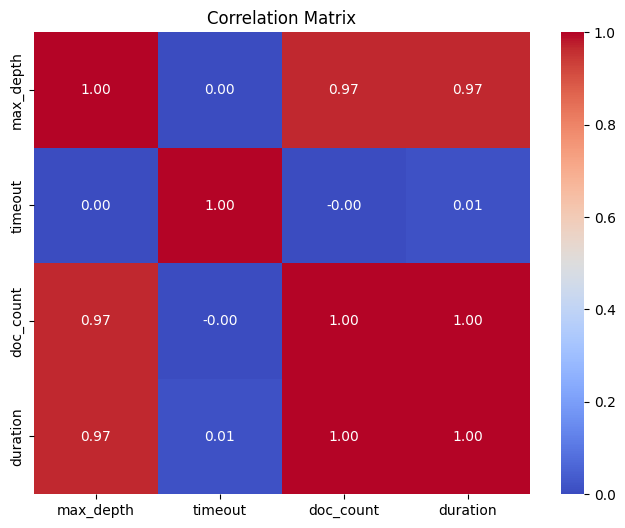

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load JSON summary into a DataFrame
summary_df = pd.DataFrame(summary_data)

# Correlation heatmap between parameters and key metrics
correlation_matrix = summary_df[['max_depth', 'timeout', 'doc_count', 'duration']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


There are some key aspects to retrieve from this matrix:
- As expected, there is a very high (perfect) correlation between the `doc_count` and `duration`, which could mean that document length isn't as important to determine extraction duration. This is to be confirmed later through the use of the extracted documents. 
- It makes sense that `max_depth` also has a high correlation both with `doc_count` and `duration`, as a more in-depth search means a higher number of documents. 
- There is almost no correlation between `timeout` and the other variables, indicating that the `timeout` settings do not strongly influence the document count or extraction time in these cases. The hope was that, by reducing the `timeout`, the extraction time would be reduced. However, by checking the `loader_experiment.log`, only 1 timeout error occurred in the whole experiment, making the change in the value of this parameter useless. However, the experiment helped to show that a 2 second `timeout` is enough and any greater value is not needed.


Now, lets focus a bit more in the `max_depth` parameter, to better understand how it relates to other variables. While there isn't much that can be analyzed without checking the document relevance, we can check for patterns between `max_depth` and `doc_count`.

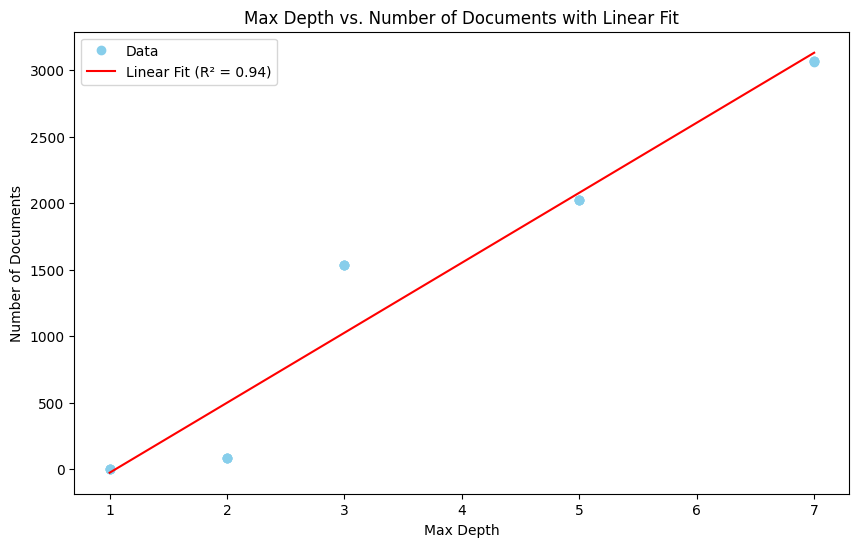

In [11]:
import matplotlib.pyplot as plt
import numpy as np

max_depths = [result['max_depth'] for result in summary_data]
doc_counts = [result['doc_count'] for result in summary_data]

# Convert to numpy arrays for easier manipulation
max_depths = np.array(max_depths)
doc_counts = np.array(doc_counts)

# Fit a linear regression line to the data
slope, intercept = np.polyfit(max_depths, doc_counts, 1)  # 1st degree polynomial (linear)
linear_fit = slope * max_depths + intercept

# Calculate R²
correlation_matrix = np.corrcoef(max_depths, doc_counts)
correlation_xy = correlation_matrix[0, 1]
r_squared = correlation_xy**2

# Plot data and linear fit
plt.figure(figsize=(10, 6))
plt.plot(max_depths, doc_counts, 'o', label='Data', color='skyblue')  # Scatter plot of data points
plt.plot(max_depths, linear_fit, 'r-', label=f'Linear Fit (R² = {r_squared:.2f})')  # Linear fit line

# Add labels and title
plt.xlabel('Max Depth')
plt.ylabel('Number of Documents')
plt.title('Max Depth vs. Number of Documents with Linear Fit')
plt.legend()

# Show the plot
plt.show()


Data seems to follow a linear tendency, with an R² of 0.94. However, given the small size of our dataset, the results aren't conclusive. Moreover, it is very possible that the number of unique extracted documents doesn't increase as quickly as the `max_depth` for a greater value of `max_depth`, for a series of reasons:
- Eventually, it won't be possible to find new URLs through a recursive search, as all the documents in the documentation will be found.
- By default, `RecursiveUrlLoader` doesn't allow the search of documents beyond the root URL, in our case `https://docs.opencv.org/4.x/`.

However, to prove this, a higher depth level would be needed, requiring lengthy tests. While this could be useful, a more insightful analysis can be done by analyzing the documents content.

Given that the `timeout` parameter is discarded now, let's pick the best set for `max_depth`. In this case, the best set would be the most complete one, or the one with the highest `doc_count`. Given the nature of `RecursiveUrlLoader`, all retrievals with the same `max_depth` would have the same number of documents; however, this isn't true given that some documents could not be retrieved given timeouts or different exceptions. A complete list of the exceptions can be checked in the [Experiment Log](loader_experiment.log), which shows that a total of 6 errors occurred during the retrieval. By having a quick look at the [Results Summary](extraction_results_summary.json), all the sets with a `timeout` value of 2 seconds are complete, so we're going to be using these from now on. We're also going to discard those sets with a `max_depth` of 1 as they only show a single document: OpenCV's index. This leaves us with only 4 sets.

Let's group up all sets for easier analysis.

In [27]:
import typing as t
import jsonlines

def load_docs_from_jsonl(file_path) -> t.Iterable[Document]:
    documents = []
    with jsonlines.open(file_path, mode="r") as reader:
        for doc in reader:
            documents.append(Document(**doc))
    return documents

docsSets = []
for set in summary_data:
    if set["timeout"] != 2:
        continue
    if set["max_depth"] == 1:
        continue
    docs = load_docs_from_jsonl(set["file"])
    docsSets.append(docs)

Let's start by having a peek at the documents length for each of the remaining sets, to check how uniform are they.

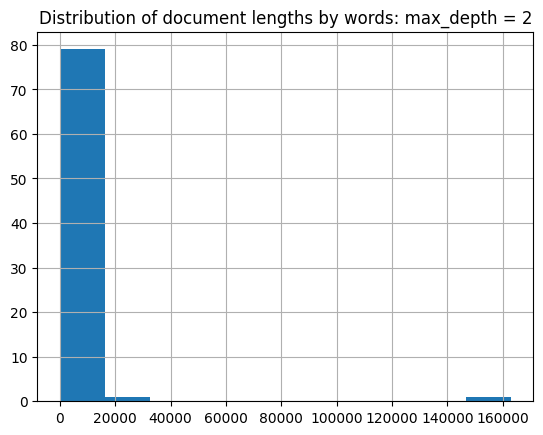

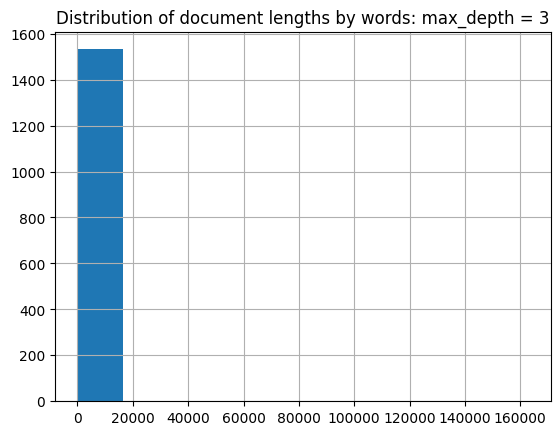

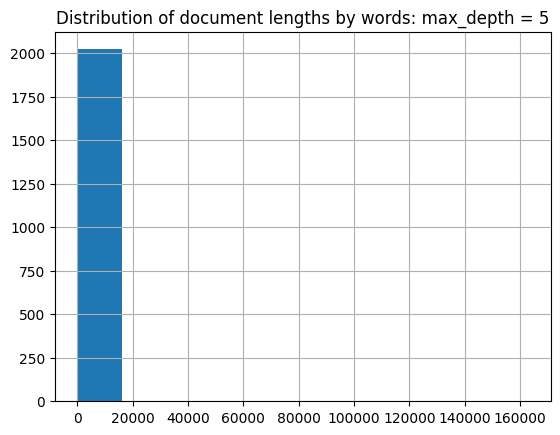

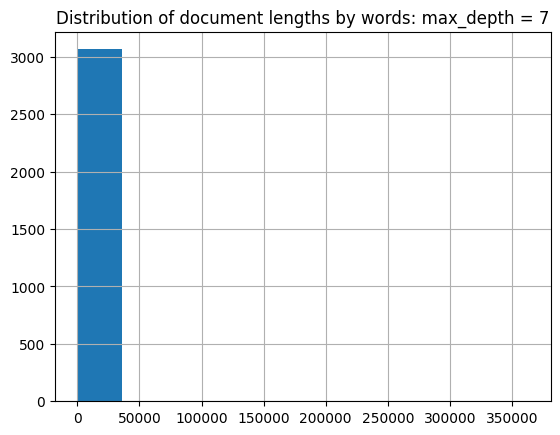

In [ ]:
titles = ["max_depth = 2", "max_depth = 3", "max_depth = 5", "max_depth = 7"]
for i, docs in enumerate(docsSets):
    lengths = [len(doc.page_content.split())for doc in docs]
    fig = pd.Series(lengths).hist()
    plt.title("Distribution of document lengths by words: " + titles[i])
    plt.show()

Seems like we have some significant outliers. Let's identify them.

In [55]:
docs = docsSets[3] #Biggest set
for doc in docs:
    length = len(doc.page_content.split())
    if length > 5000:
        print(doc.metadata["source"] + ": " + str(length))

https://docs.opencv.org/4.x/d0/de3/citelist.html: 8025
https://docs.opencv.org/4.x/d2/d75/namespacecv.html: 35176
https://docs.opencv.org/4.x/dc/d84/group__core__basic.html: 5156
https://docs.opencv.org/4.x/d2/de8/group__core__array.html: 24171
https://docs.opencv.org/4.x/d3/d63/classcv_1_1Mat.html: 14812
https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html: 6221
https://docs.opencv.org/4.x/d1/d4f/imgproc_2include_2opencv2_2imgproc_8hpp.html: 5040
https://docs.opencv.org/4.x/db/de0/group__core__utils.html: 9940
https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html: 28810
https://docs.opencv.org/4.x/df/dfc/classcv_1_1Mat__.html: 5238
https://docs.opencv.org/4.x/d3/d23/classcv_1_1hdf_1_1HDF5.html: 5649
https://docs.opencv.org/4.x/d8/d34/group__cudaarithm__elem.html: 5346
https://docs.opencv.org/4.x/d4/d1c/namespacecv_1_1gapi.html: 7104
https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html: 6004
https://docs.opencv.org/4.x/df/d91/group__core__hal__intrin.html: 19761
htt

Seems like the biggest documents cover `namespace` lists, tutorials and the more complex classes, between others. Some of these documents can be safely removed from our knowledge base as they are specific to C++, but this something we'll handle later. One particular file that stands out is `https://docs.opencv.org/4.x/opencv.tag`, which is a **Doxygen tag file**, used mainly for interlinking documentation. It doesn't contain human-readable documentation, so it can be safely removed. It is important to have noted this file as it is ten times bigger than even the largest documents.

Let's try plotting the histograms again, ignoring for now the biggest files, so that a better distribution of the files can be achieved.

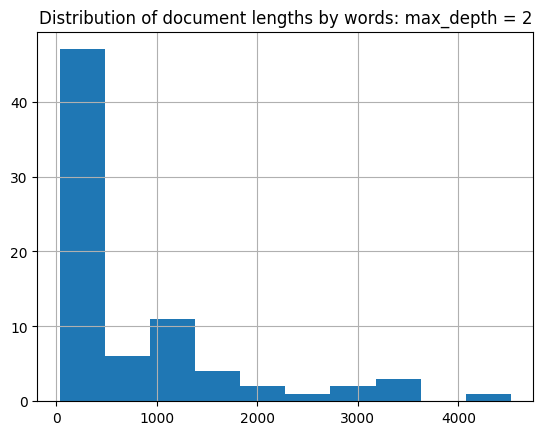

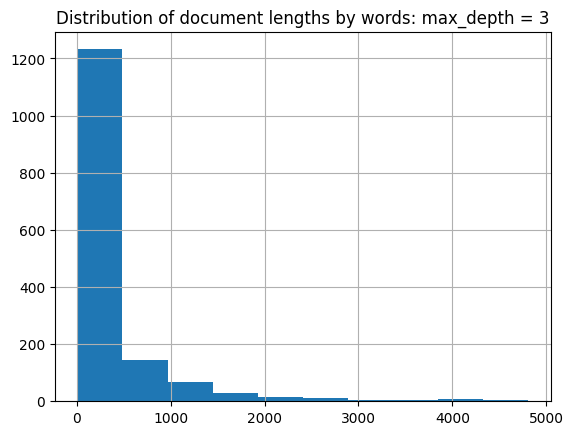

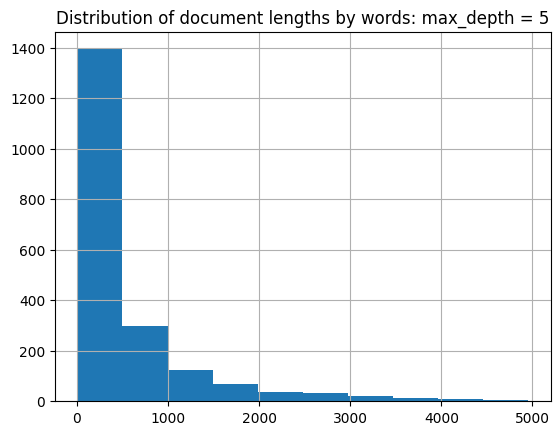

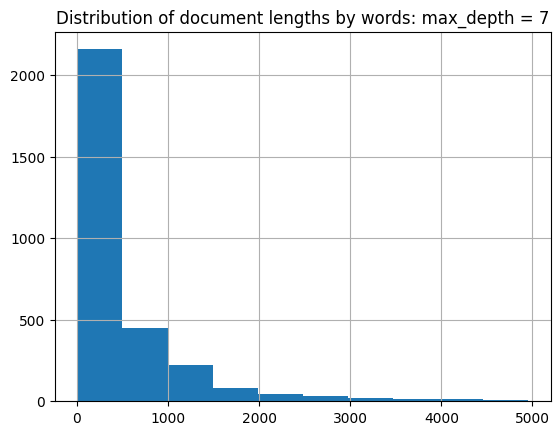

In [58]:
for i, docs in enumerate(docsSets):
    lengths = [len(doc.page_content.split())for doc in docs]
    lengths = filter(lambda l: l < 5000, lengths)
    fig = pd.Series(lengths).hist()
    plt.title("Distribution of document lengths by words: " + titles[i])
    plt.show()

Seems like we have a lot of very short documents. Some of them might be useful, and some of them might not. Knowing this will be the main task of the relevance measurement. 

Now, let's make sure we don't have repeated documents:

In [65]:
docs = docsSets[3] #Biggest set
unique_urls = []
for doc in docs:
    if doc.metadata["source"] not in unique_urls:
        unique_urls.append(doc.metadata["source"])
    else:
        print(doc.metadata["title"])
        print(doc.metadata["source"])
print("Total documents: " + str(len(docs)))
print("Unique documents: " + str(len(unique_urls)))

Total documents: 3067
Unique documents: 3067


Finally, let's look for documents that may have non-unique names, as this will give us an idea of documents that may be redundant or useless for our knowledge base:

In [66]:
docs = docsSets[3] #Biggest set
unique_titles = []
for doc in docs:
    if doc.metadata["title"] not in unique_titles:
        unique_titles.append(doc.metadata["title"])
    else:
        print(doc.metadata["title"])
        print(doc.metadata["source"])

OpenCV: Member List
https://docs.opencv.org/4.x/d9/d6b/classcv_1_1GCall-members.html
OpenCV: Member List
https://docs.opencv.org/4.x/d7/d82/structcv_1_1V__TypeTraits_3_01int64_01_4-members.html
OpenCV: Member List
https://docs.opencv.org/4.x/d4/ded/classcv_1_1AVIReadContainer-members.html
OpenCV: Member List
https://docs.opencv.org/4.x/d6/d13/classcv_1_1GeneralizedHoughGuil-members.html
OpenCV: Member List
https://docs.opencv.org/4.x/d5/d2d/classcv_1_1Complex-members.html
OpenCV: Member List
https://docs.opencv.org/4.x/d1/d7b/classcv_1_1GKernelTypeM_3_01K_00_01std_1_1function_3_01std_1_1tuple_3_01R_8_8_8_01_4_07Args_8_8_8_08_4_01_4-members.html
OpenCV: Member List
https://docs.opencv.org/4.x/d8/d23/classcv_1_1QuatEnum-members.html
OpenCV: Member List
https://docs.opencv.org/4.x/d2/d8c/classcv_1_1RotatedRect-members.html
OpenCV: Member List
https://docs.opencv.org/4.x/d2/d33/classcv_1_1MatConstIterator-members.html
OpenCV: Member List
https://docs.opencv.org/4.x/de/d37/classcv_1_1Tracke

It seems there are many repeated titles. Giving it a close look, this is what is most common:
- **Member Lists**: Pages that list components of each class, without giving further information on them. While these were helpful to obtain links to each member, they don't provide useful information for our RAG and can be discarded.
- **404 Not Found**: It seems like there are some broken links in OpenCV's documentation. These can also be discarded.
- **Tutorials**: It looks like many tutorials share their name with the library to which it is referring to, but they are very useful for us, so we keep them.
- **Directory references**: Again, these don't seem useful due to the short content they provide. Many documents may be deleted depending on their length during pre-processing.

This initial analysis will be very useful to indicate document relevance in OpenCV's documentation. But before we move on to measuring relevance, our next goal is to obtain more information from other sites; namely, LearnOpenCV and Youtube. Let's get to it!

#### Obtaining additional information from other sources <a class="anchor" id="new-sources"></a>

Let's start extracting information from [LearnOpenCV](https://learnopencv.com/). These are a series of guides that cover many of the features in OpenCV. It's a great way to learn OpenCV for both Python and C++. The guides include explanations and code, besides images and videos to explain the main features of each library. An initial approach is to simply remove all multimedia, while a more complex approach would be to have multimedia integration with the RAG, which could be its own project. This approach could be explored more in the future.

For now, lets explore the guides inside LearnOpenCV. At first glance at [Getting Started with OpenCV](https://learnopencv.com/getting-started-with-opencv/), it seems we have a 16-chapter tutorial that covers OpenCV's basics. Let's start by extracting the information through a `UnstructuredURLLoader`.

#### Generating a relevance measurement <a class="anchor" id="relevance-measurement"></a>

There are multiple approaches we can follow when creating a relevance measurement. But before we get into it, we can safely discard many documents given the initial performed analysis. To do this, we will use our biggest dataset.

In [5]:
from  langchain.schema import Document
import json
from glob import glob
import typing as t
import jsonlines

summary_files = glob("extraction_results_summary.json")
summary_data = []
for file in summary_files:
    with open(file, "r") as f:
        summary_data.extend(json.load(f))



def load_docs_from_jsonl(file_path) -> t.Iterable[Document]:
    documents = []
    with jsonlines.open(file_path, mode="r") as reader:
        for doc in reader:
            documents.append(Document(**doc))
    return documents

docsSets = []
docs_path = list(filter(lambda d: d["max_depth"] == 7 and d["timeout"] == 2, summary_data))[0]["file"]
docs = load_docs_from_jsonl(docs_path)

Let's start by removing documents that we know we don't need:
- Namespace references
- Device Layer: a huge list of structures for OpenCV focused on C++.
- Bibliography
- Deoxygen tag file
- Member Lists
- 404 files
- Directory References

In [6]:
filtered_docs = list(filter(lambda d:
                       "Namespace Reference" not in d.metadata["title"] and
                       "Device layer" not in d.metadata["title"] and
                       "Bibliography" not in d.metadata["title"] and
                       "https://docs.opencv.org/4.x/opencv.tag" not in d.metadata["source"] and
                       "Member List" not in d.metadata["title"] and
                       "404 Not Found" not in d.metadata["title"] and
                       "Directory Reference" not in d.metadata["title"],
                       docs))

print("Original size: " + str(len(docs)))
print("Filtered size: " + str(len(filtered_docs)))

Original size: 3067
Filtered size: 2664


We removed ~400 documents, reducing the size of our set by ~13%.

The initial strategy to define document relevance is to use an LLM to clasify each document using 5 criteria:
- **Relevance**: How closely does the document align with Python usage or general usability within the context of OpenCV?
- **Completeness**: Does the document contain enough information for a useful reference or guide, or is it missing key explanations?
- **Readability**: Is the document easy to understand, with a clear structure that would be helpful in a conversational or retrieval system?
- **Technical Level**: Is the document’s level of technical detail appropriate for a Python user, or is it overly C++-focused?
- **Python-Specific Usability**: Even if Python isn’t mentioned, does the content cover features or classes that are accessible in Python?

This is just a first test and the criteria may change, but it is designed to cover the most important aspects of our RAG system. For each criterion, the LLM is going to be asked to give it a rating between 1 and 5. However, given the subjectiveness of this rating, results are not expected to be great. If this is the case, the prompt given to the LLM will contain rating examples as a reference. Let's try this for 20 documents at random. We're going to use [Mistral-7B-Instruct-v0.2](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2), a relatively small but fast LLM, known for its accuracy in text generation given a template.

First, we create a prompt template indicating each criterion and its pertinent description, and giving a clear JSON format for which it should return the results.

In [38]:
prompt_template = """
I'm going to give you a document, delimited by «», regarding OpenCV's documentation. Please rate the document from 1 to 5 on 
each criterion below, with 1 meaning low relevance or quality and 5 meaning high relevance or quality.

- **Relevance** (1-5): How closely does the document align with Python usage or general usability within the context of OpenCV?
- **Completeness** (1-5): Does the document contain sufficient information for reference or guidance, or does it lack key explanations?
- **Readability** (1-5): Is the document easy to understand, with a clear structure that aids comprehension in a retrieval system?
- **Technical Level** (1-5): Is the level of technical detail suitable for a Python user, or is it overly focused on C++?
- **Python-Specific Usability** (1-5): Even if Python isn't directly mentioned, does the content cover features or classes that are accessible to Python users?

Please respond exactly in the JSON format shown below, and don't response anything else. Remember to include curly braces '{{', '}}' in your answer:

This is the JSON format:
{{
    "relevance": x,
    "completeness": x,
    "readability": x,
    "technicallevel": x,
    "pythonusability": x,
    "explanation": "str"
}}

Remember not to add any other comments, explanations, or text to your answer. Remember to include curly braces '{{', '}}' in your answer.

This is the document:
«{text}»
"""


As we're going to use the `Inference API`, we need a valid key to generate texts. You can get your token [here](https://huggingface.co/settings/tokens/new?globalPermissions=inference.serverless.write&tokenType=fineGrained). Let's try our prompt with 20 random documents from our set. Also, we're going to set the `max_tokens` parameter of our model to 500, to ensure a quick answer (2-4 seconds).

In [39]:
from huggingface_hub import InferenceClient
from dotenv import load_dotenv
import os
import random

load_dotenv()
api_key = os.getenv("INFERENCE_API_KEY")
client = InferenceClient(api_key=api_key)
model = "mistralai/Mistral-7B-Instruct-v0.2"
random_sample = random.sample(filtered_docs, 20)

for doc in random_sample:
	prompt = prompt_template.format(text=doc.page_content)
	messages = [
		{
			"role": "user",
			"content": prompt
		}
	]
	stream = client.chat.completions.create(
		model=model, 
		messages=messages, 
		max_tokens=500,
		stream=True
	)
	print("\n============Document title============")
	print(doc.metadata["title"])
	print("==========Source==========")
	print(doc.metadata["source"])
	print("==========Rating==========")
	for chunk in stream:
		print(chunk.choices[0].delta.content, end="")


============Document title============
OpenCV: cv::saliency::StaticSaliency Class Reference
==========Source==========
https://docs.opencv.org/4.x/d5/d87/classcv_1_1saliency_1_1StaticSaliency.html
==========Rating==========
 {
"relevance": 4,
"completeness": 5,
"readability": 5,
"technicallevel": 3,
"pythonusability": 5,
"explanation": "The document provides the OpenCV Class Reference for cv::saliency::StaticSaliency, detailing its member functions, protected functions, and inherited functions. It also includes Python bindings and explanations for each function."
}
============Document title============
OpenCV: Graph API: Image Structural Analysis and Shape Descriptors
==========Source==========
https://docs.opencv.org/4.x/d3/d01/group__gapi__shape.html
==========Rating==========
 {
"relevance": 5,
"completeness": 5,
"readability": 5,
"technicallevel": 4,
"pythonusability": 5,
"explanation": "This document provides comprehensive information about the OpenCV functions related to image 

Now... I confess I struggled asking the LLM for a valid JSON format that didn't include any additional comments. Even when I begged it to stop making additional comments, it did. My solution to this was to include an `explanation` key so that the LLM was forced to include its explanation there. By using this technique, the answers were more consistent and, as far as I know, no formatting errors have occurred. As a side-benefit, we can see the reasoning of the LLM for this initial sample and see if we agree.

Regarding the ratings given to each document, I was surprisingly pleased with how each dimension was rated. However, it became clear that some dimensions were more important than others:

- **Relevance**: It seemed like the LLM was very "binary" when rating this dimension, as most documents were given either a 1 or a 5. There are some exceptions to this rule, but it seems like this will be a very important dimension in order to discard some documents. Those documents that **did** receive a 1 were definitely irrelevant, as they were too short, or completely focused on C++-only classes.
- **Completeness**: Again, a very important dimension. The LLM was able to identify which documents didn't include explanations, were too short to be of use, or were completely comprised of function lists.
- **Readability**: This dimension might not be as useful as the others, mainly because most documents got a 5 in this criterion. Additionally, in the case that a particular document is hard to read, the RAG's LLM should be able to make it easier to understand for the user. It will be interesting to see which documents get a low rating in this criterion when all of them get rated.
- **Technical level**: This is another dimension that might not be as important as the others. Not because the technical level is not important, but because it seems to have a high correlation both with `Relevance` and `Python Usability`. A future quantitative analysis might show if this is true.
- **Python usability**: This seems like the most important dimension, by reviewing the small sample. Looks like the LLM is a good judge of the relevance of a document for Python users, as it gave bad ratings to C++ headers. However, some documents that could be useful for Python users were given a 3 in this dimension, meaning that the final filter should be more lenient regarding this particular dimension. 

Ok, let's make our code a bit more analysis-friendly. Let's add the document URL, which will serve as the ID for our document. This way, we can start analyzing how exactly we're going to remove documents from our dataset. While we did our best to make the LLM generate valid JSON outputs, some errors may arise. These are the errors that were examined through multiple tests and that are going to be avoided during ranking:

- **New lines**: When writing the explanation, the LLM sometimes used new lines, which could break the JSON parser.
- **Backslashes**: Sometimes the model added backslashes (`\`) to the output, which the JSON parser didn't understand.
- **Missing right brackets**: In some responses, the ending bracket (`}`) was missing. If this is the case, it's added before parsing. 
- **Document size**: Some documents were too big and the generated tokens exceeded the maximum number of allowed tokens. These were detected and splitted recursively.

Let's try and load each JSON and add the URL to it. If we can't load it, we'll still generate a JSON with the response. Hopefully, not many errors will arise and a manual fix is possible. Given that all the documents found in the set with a `max_depth` of 7 will also be found in all other datsets, there is no need of rating the documents for each dataset; instead, it's only necessary to link the rating to each document for the remaining datasets.

In [40]:
from transformers import AutoTokenizer
from langchain.text_splitter import RecursiveCharacterTextSplitter
def split_text(
        text: str,
        tokenizer_name: str,
        chunk_size: int
) -> list[str]:
    MARKDOWN_SEPARATORS = [
        "\n#{1,6} ",
        "```\n",
        "\n\\*\\*\\*+\n",
        "\n---+\n",
        "\n___+\n",
        "\n\n",
        "\n",
        " ",
        "",
    ]
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size/10), # 10% overlap
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )
    return text_splitter.split_text(text)

Let's run our rater. Given that each document will be rated individually, and thus, be considered a separate response from the LLM, a long processing time (~3 hours) is expected. The final ratings will be saved in a JSON file. If you don't feel like waiting 3 hours for the LLM to do its job, you can safely skip this step and analyze the resulting `Mistral7B_Ratings.json` file, found on `/data/ExtractedDocuments/Exploratory/RelevanceMeasurement/`. 

In [ ]:
from huggingface_hub import InferenceClient
from dotenv import load_dotenv
import os
import json
from transformers import AutoTokenizer
from langchain.text_splitter import RecursiveCharacterTextSplitter
def split_text(
        text: str,
        tokenizer_name: str,
        chunk_size: int
) -> list[str]:
    MARKDOWN_SEPARATORS = [
        "\n#{1,6} ",
        "```\n",
        "\n\\*\\*\\*+\n",
        "\n---+\n",
        "\n___+\n",
        "\n\n",
        "\n",
        " ",
        "",
    ]
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size/10), # 10% overlap
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )
    return text_splitter.split_text(text)


# Directory to save extracted documents
os.makedirs("../data/ExtractedDocuments/Exploratory/RelevanceMeasurement", exist_ok=True)

load_dotenv()
api_key = os.getenv("INFERENCE_API_KEY")
client = InferenceClient(api_key=api_key)
model = "mistralai/Mistral-7B-Instruct-v0.2"
tokenizer = AutoTokenizer.from_pretrained(model)
max_chunk_size = 31000 # We leave space for max_new_tokens (500) and the prompt template (As time of writting, 390)      
docs_relevance = []
n = 0
correct_format = 0
incorrect_format = 0
for doc in filtered_docs:
    document_url = doc.metadata["source"]
    doc_length = len(tokenizer(doc.page_content)["input_ids"])
    if doc_length > max_chunk_size:
        texts = split_text(doc.page_content, tokenizer_name=model, chunk_size=max_chunk_size)
        print("===Big document===")
        print("URL: " + document_url)
        print("Splitted in " + str(len(texts)) + " chunks.")
    else:
        texts = [doc.page_content]
    for i, page_content in enumerate(texts):
        prompt = prompt_template.format(text=page_content)
        messages = [
            {
                "role": "user",
                "content": prompt
            }
        ]
        stream = client.chat.completions.create(
            model=model, 
            messages=messages, 
            max_tokens=500,
            stream=True
        )
        
        # Collect and process each chunk
        response = ""
        for chunk in stream:
            response += chunk.choices[0].delta.content
        response = response.replace('\n', ' ')
        response = response.replace('\\', '')
        if response[-1] != '}':
            response += '}'
        add_chunk_idx = {"chunk_idx": i}
        add_url = {"url": document_url}
        try:
            response_data = json.loads(response)
            response_data.update(add_chunk_idx)
            response_data.update(add_url)
            correct_format += 1
        except json.JSONDecodeError:
        # If there is an error, create a JSON with "url" and "invalidJson" fields
            response_data = {
                "invalidJson": response,
                "chunk_idx": i,
                "url": document_url
            }
            print("===Invalid JSON===")
            print("Response:\n")
            print(response)
            print("Source: " + document_url)
            incorrect_format += 1
        docs_relevance.append(response_data)
        n+=1
        if (n) % 100 == 0:
            print("=========================")
            print(str(n) + " documents rated.")
            print(str(correct_format) + " documents formated correctly.")
            print(str(incorrect_format) + " documents unabled to be formatted.")

relevance_filename = f"../data/ExtractedDocuments/Exploratory/RelevanceMeasurement/Mistral7B_Ratings.json"
with open(relevance_filename, "w") as relevance_file:
    json.dump(docs_relevance, relevance_file)
print(f"\nSummary saved to {relevance_filename}")

It seems there were few errors in the JSON formatting, let's delve deeper. 

**Note**: The next blocks assume you're starting a new session and you don't have access to old variables, given the long time it may take for the LLM to rate the documents.

In [5]:
import json
relevance_filename = "../data/ExtractedDocuments/Exploratory/RelevanceMeasurement/Mistral7B_Ratings.json"
with open(relevance_filename) as relevance_file:
    relevance_ratings = json.load(relevance_file)
failed_jsons = [r for r in relevance_ratings if "invalidJson" in r]
print(len(failed_jsons))
print("========")
for failed_json in failed_jsons:
    print(failed_json["url"])

25
https://docs.opencv.org/4.x/d5/d51/group__features2d__main.html
https://docs.opencv.org/4.x/db/de0/group__core__utils.html
https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html
https://docs.opencv.org/4.x/d4/d40/samples_2cpp_2watershed_8cpp-example.html
https://docs.opencv.org/4.x/d5/d54/group__objdetect.html
https://docs.opencv.org/4.x/d2/d1a/classcv_1_1aruco_1_1ArucoDetector.html
https://docs.opencv.org/4.x/da/d64/warpers_8hpp.html
https://docs.opencv.org/4.x/d7/d68/structcv_1_1ParamType_3_01unsigned_01_4.html
https://docs.opencv.org/4.x/df/d91/group__core__hal__intrin.html
https://docs.opencv.org/4.x/da/d80/classcv_1_1viz_1_1WTrajectoryFrustums.html
https://docs.opencv.org/4.x/dc/d1e/structcv_1_1datasets_1_1SR__bsdsObj.html
https://docs.opencv.org/4.x/dc/dfc/group__videoio__flags__others.html
https://docs.opencv.org/4.x/d7/d86/classcv_1_1dnn_1_1CropLayer.html
https://docs.opencv.org/4.x/d7/d67/structcv_1_1cudev_1_1exp__func_3_01short_01_4.html
https://docs.opencv.org/4.x/d7/d9d/

There are only 25 failed JSONs. That doesn't seem that bad, lets peek at one of them to see what the error was:

In [32]:
import random
import textwrap

wrapper = textwrap.TextWrapper(width=50) 

sample = random.sample(failed_jsons,1)[0]
print(sample["url"])
word_list = wrapper.wrap(text=sample["invalidJson"]) 
for element in word_list:
    print(element)

https://docs.opencv.org/4.x/d7/d9d/structcv_1_1cudev_1_1tan__func_3_01schar_01_4.html
 { "relevance": 1, "completeness": 3,
"readability": 4, "technicallevel": 5,
"pythonusability": 1, "explanation": "This
document describes the OpenCV CUDA-accelerated
"cv::cudev::tan_func<schar>" struct, its public
member functions, and their usage. However, it
lacks relevance for Python users, as the usage
examples and explanations are provided for C++
only." }


By checking some of the invalid JSONs, it seems like the errors were one of the following:
- Using symbols that may break the JSON format (`{`, `}` or `"`).
- Not abiding by the formatting rules.
    - Not including an `explanation` key and instead explaining the reasoning below.
    - Creating a preface to the JSON structure.
    - Using double (double) quotes (`""`).
    - Giving an explanation to the explanation, for some reason.

Given that only 25 documents were badly formatted, a manual fix is feasible. The manual fixes are placed on the file `Mistral7B_Ratings_Manual_Fixes.json`.

**Note**: For one particular document (url: `https://docs.opencv.org/4.x/df/d91/group__core__hal__intrin.html`) the response was completely broken. The model was run again for this specific document.

Let's now check the integrity of our files. Specifically, let's see if there are documents for which the keys were generated with a wrong name or without a category.

In [57]:
import json
relevance_filename_manual = "../data/ExtractedDocuments/Exploratory/RelevanceMeasurement/Mistral7B_Ratings_invalid_json_fixes.json"
with open(relevance_filename_manual) as relevance_file:
    relevance_ratings_manual = json.load(relevance_file)
no_relevance = [r for r in relevance_ratings_manual if "relevance" not in r]
no_completeness = [r for r in relevance_ratings_manual if "completeness" not in r]
no_readability = [r for r in relevance_ratings_manual if "readability" not in r]
no_technicallevel = [r for r in relevance_ratings_manual if "technicallevel" not in r]
no_pythonusability = [r for r in relevance_ratings_manual if "pythonusability" not in r]
no_explanation = [r for r in relevance_ratings_manual if "explanation" not in r]
print("Without relevance: " + str(len(no_relevance)))
print("Without completeness: " + str(len(no_completeness)))
print("Without readability: " + str(len(no_readability)))
print("Without technical level: " + str(len(no_technicallevel)))
print("Without Python usability: " + str(len(no_pythonusability)))
print("Without explanation: " + str(len(no_explanation)))

Without relevance: 0
Without completeness: 11
Without readability: 0
Without technical level: 0
Without Python usability: 3
Without explanation: 19


It seems we have issues with `completeness`, `pythonusability` and `explanation`. Let's focus on completeness and Python usability for now, as these are important metrics for our relevance study. There is no direct use for explanation as for now, so we'll ignore this errors temporarily.

In [52]:
print("===Completeness===")
for ratings in no_completeness:
    print(ratings)
    print("=====")
print("===Python usability===")
for ratings in no_pythonusability:
    print(ratings)
    print("=====")

===Completeness===
{'relevance': 5, 'compleateness': 5, 'readability': 5, 'technicallevel': 4, 'pythonusability': 5, 'explanation': "This document provides detailed descriptions and usage examples for several utility functions in OpenCV's samples module for Python users. It includes method signatures, parameter descriptions, and code snippets for calling the functions in Python. The technical level is somewhat higher due to the inclusion of code snippets and a brief call graph, but the information is still accessible and useful for Python users.", 'chunk_idx': 0, 'url': 'https://docs.opencv.org/4.x/d6/dba/group__core__utils__samples.html'}
=====
{'relevance': 4, 'completesness': 5, 'readability': 4, 'technicallevel': 3, 'pythonusability': 4, 'explanation': 'The document discusses an OpenCV sample program written in C++ that demonstrates the use of applyColorMap function. Although not specifically written for Python, the document provides an explanation of various OpenCV functions used,

Gladly, the model *did* generate ratings for the broken JSONs; the issue was that Mistral7B seems to struggle typing `completeness` and was able to write it in 7 different ways (quite an achievement). Regarding `pythonusability`, seems like the model added a space and a hyphen sometimes for this specific dimension. In any case, these documents were manually corrected and are available in `Mistral7B_Ratings_dimension_fixes.json`. 

Let's check if all the manual fixes were correctly applied in `Mistral7B_Ratings_dimension_fixes.json` and check if all the ratings are integers.

In [66]:
import json
ratings_filename_manual = "../data/ExtractedDocuments/Exploratory/RelevanceMeasurement/Mistral7B_Ratings_dimension_fixes.json"
with open(ratings_filename_manual) as ratings_file:
    ratings_manual = json.load(ratings_file)
print("Total documents: " + str(len(relevance_ratings_manual)))
relevance = [r for r in ratings_manual if "relevance" in r and isinstance(r["relevance"], int)]
completeness = [r for r in ratings_manual if "completeness" in r and isinstance(r["completeness"], int)]
readability = [r for r in ratings_manual if "readability" in r and isinstance(r["readability"], int)]
technicallevel = [r for r in ratings_manual if "technicallevel" in r and isinstance(r["technicallevel"], int)]
pythonusability = [r for r in ratings_manual if "pythonusability" in r and isinstance(r["pythonusability"], int)]
print("With relevance: " + str(len(relevance)))
print("With completeness: " + str(len(completeness)))
print("With readability: " + str(len(readability)))
print("With technical level: " + str(len(technicallevel)))
print("With Python usability: " + str(len(pythonusability)))

Total documents: 2672
With relevance: 2672
With completeness: 2672
With readability: 2672
With technical level: 2672
With Python usability: 2672


As a last check, let's see what's the range of each dimension, to make sure that the LLM followed the guidelines:

In [73]:
print("==Relevance==")
print("Min: " + str(min(r["relevance"] for r in ratings_manual)) + ", Max: " + str(max(r["relevance"] for r in ratings_manual)))
print("==Completeness==")
print("Min: " + str(min(r["completeness"] for r in ratings_manual)) + ", Max: " + str(max(r["completeness"] for r in ratings_manual)))
print("==Readability==")
print("Min: " + str(min(r["readability"] for r in ratings_manual)) + ", Max: " + str(max(r["readability"] for r in ratings_manual)))
print("==Technical Level==")
print("Min: " + str(min(r["technicallevel"] for r in ratings_manual)) + ", Max: " + str(max(r["technicallevel"] for r in ratings_manual)))
print("==Python Usability==")
print("Min: " + str(min(r["pythonusability"] for r in ratings_manual)) + ", Max: " + str(max(r["pythonusability"] for r in ratings_manual)))

==Relevance==
Min: 1, Max: 5
==Completeness==
Min: 1, Max: 5
==Readability==
Min: 1, Max: 5
==Technical Level==
Min: 0, Max: 5
==Python Usability==
Min: 0, Max: 5


Seems like some documents were so irrelevant both for technical level and python usability that the LLM decided to ignore the provided scale. I think it's safe to change these 0 ratings to 1. Let's do that and save it in the final version of our ratings JSON, `Mistral7B_Ratings_Final.json`.

In [76]:
ratings = ratings_manual
for rating in ratings:
    if rating["technicallevel"] < 1:
        rating["technicallevel"] = 1
    if rating["pythonusability"] < 1:
        rating["pythonusability"] = 1

ratings_filename = f"../data/ExtractedDocuments/Exploratory/RelevanceMeasurement/Mistral7B_Ratings_Final.json"
with open(ratings_filename, "w") as ratings_file:
    json.dump(ratings, ratings_file)


Ok, now we're ready to start analyzing the documents! Let's first check if the LLM had uniform ratings for each category or if there was some sort of bias:

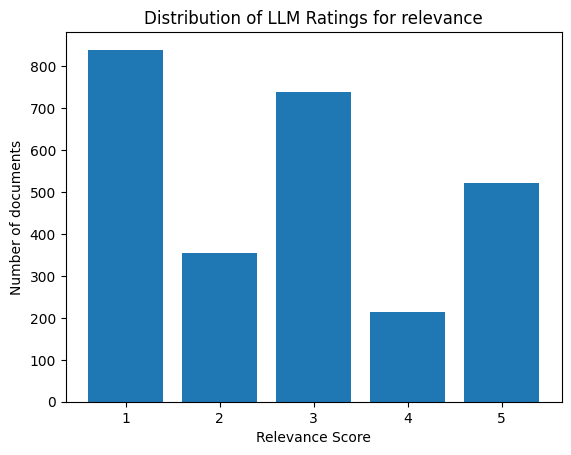

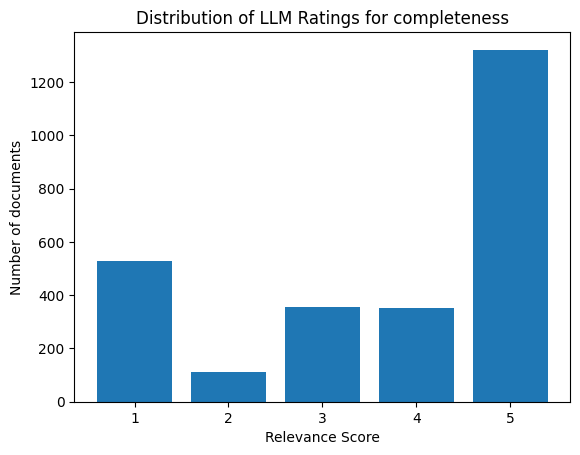

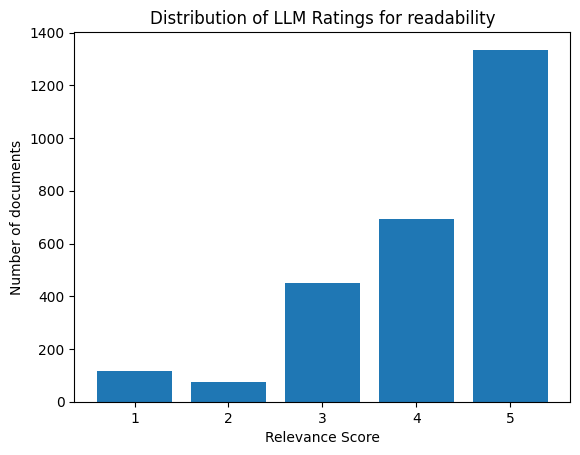

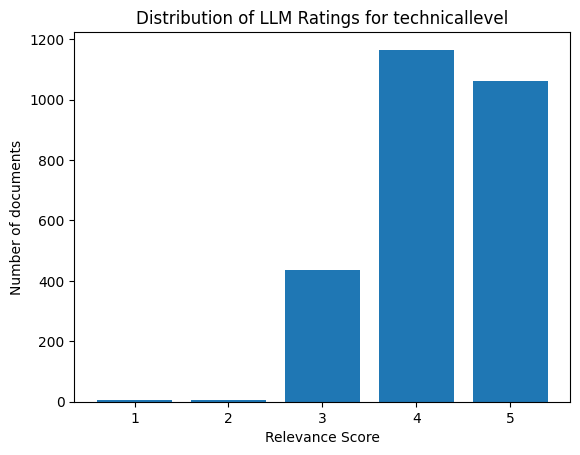

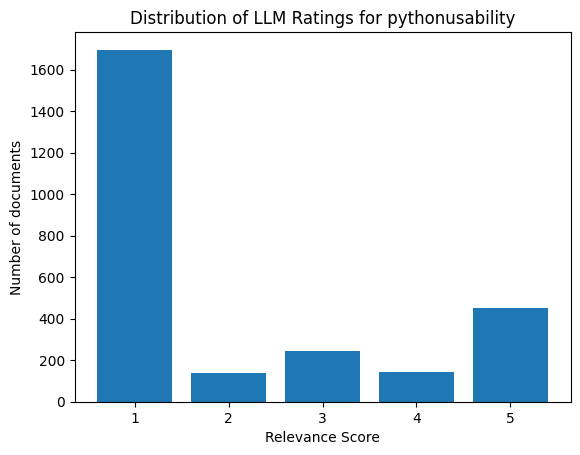

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
dimension_ratings = []
dimensions = [
    "relevance",
    "completeness",
    "readability",
    "technicallevel",
    "pythonusability"
]
for dimension in dimensions:
    dimension_ratings.append([rating[dimension] for rating in ratings])

for i, dimension_rating in enumerate(dimension_ratings):
    fig = pd.Series(dimension_ratings[i]).hist(
        bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5],  # Set bins to align with whole numbers
        grid=False,
        rwidth=0.8
    )

    plt.xticks([1, 2, 3, 4, 5])  # Set ticks to 1-5
    plt.xlabel("Relevance Score")
    plt.ylabel("Number of documents")
    plt.title("Distribution of LLM Ratings for " + dimensions[i])
    plt.show()


Some initial notes from this superficial data:

- **Relevance**: Interesting how the LLM decided to classify each document in either extreme or the middle, mostly ignoring ratings of `2` and `4`. It remains to be seen if `3` is good enough for this dimension.
- **Completeness**: Similarly to relevance, most documents were given a `1` or a `5`. We'll have to address how important is this dimension. If I find out this dimension is really important, it could be a very good deciding factor to indicate if we keep a document or not.
- **Readability**: Seems like the tendency is to have a high readability . This isn't really surprising as all the documents come from the same documentation, and a minimum standard is required in readability. I'm wondering however which documents were given low ratings in this dimension. We'll check that later.
- **Technical level**: Almost all of the documents were given a `3` or greater rating for this dimension. Given that these are documentation articles, this isn't surprising, and the dimension might be useless. However, a further exploration will be done to decide if `3` is good enough.
- **Python Usability**: Now *this* is the worrying dimension. It seems like a very big amount of articles are not relevant for Python, and it is important to know why the LLM thinks this. The real issue is that, if the LLM is right, this dimension might be responsible of the removal of a big chunk of documents, making our RAG knowledge base quite small. Furthermore, it is important to decide if a score of `3` is good enough for this dimension, as it would give us more documents to work with.

##### Relevance
Let's check a small sample of documents for the most relevant scores in this dimension: `1`,`3` and `5`.

In [99]:
relevance_ratings = dimension_ratings[0]
wrapper = textwrap.TextWrapper(width=100) 

def printSampleAndExplanations(subset, k=5):
    sample = random.sample(subset, k)
    for doc in sample:
        print(doc["url"])
        if "explanation" in doc:
            word_list = wrapper.wrap(text=doc["explanation"]) 
            for element in word_list:
                print(element)

In [ ]:


print("===Low Relevance===")
printSampleAndExplanations([r for r in ratings if r["relevance"] == 1])
print("===Medium Relevance===")
printSampleAndExplanations([r for r in ratings if r["relevance"] == 3])
print("===High Relevance===")
printSampleAndExplanations([r for r in ratings if r["relevance"] == 5])

===Low Relevance===
https://docs.opencv.org/4.x/df/d23/classcv_1_1cuda_1_1BackgroundSubtractorMOG2.html
OpenCV's cv::cuda::BackgroundSubtractorMOG2 class reference for CUDA-accelerated Gaussian Mixture-
based background segmentation algorithm.
https://docs.opencv.org/4.x/d1/df9/structcv_1_1utils_1_1logging_1_1LogTagAuto.html
This document describes the cv::utils::logging::LogTagAuto struct in OpenCV's C++ implementation. It
provides no relevant information for Python users.
https://docs.opencv.org/4.x/d3/d43/structcv_1_1cudev_1_1BGRA__to__HSV__FULL__func_3_01float_01_4.html
This document provides information on the 'cv::cudev::BGRA_to_HSV_FULL_func< float >' struct from
the OpenCV CUDA-accelerated Computer Vision device layer, written in C++. It does not directly apply
to Python usage or relevance as it is specific to CUDA programming.
https://docs.opencv.org/4.x/dd/dad/structcv_1_1cudev_1_1log__func_3_01double_01_4.html
This document describes the 'cv::cudev::log_func< double >' struc

Looking at these documents one by one, I tend to agree with the assessment made by the LLM. 

- The 1-rated articles are class and struct references that, no only bring little to no information by their own, but the focus is entirely on C++. The ifnormation could be conceptually useful for Python developers willing to understand more about the background of certain modules, but there's a huge extra effort involved.
- The 3-rated articles are mostly comprised of even more file references with almost no information regarding their use (I would have personally rated them 1 or 2 as well). There's an interesting [exception to the rule](https://docs.opencv.org/4.x/db/db3/tutorial_js_table_of_contents_transforms.html), which is an index to Image Transform tutorials in OpenCV.js. This is not the tutorial per se however, and only a link to it. [The real tutorial](https://docs.opencv.org/4.x/dd/d02/tutorial_js_fourier_transform.html) is a very complete tutorial regarding how to use OpenCV in JavaScript. While it's not focused on Python, some of the information on it might be useful for Python users, and I'm curious regarding how it was rated in each dimension. We'll do this next.
- The 5-rated articles are definitely relevant, as they are all tutorials of different modules in OpenCV that have the option to show the tutorial in Python. I have no complaints regarding these assessments.

I am inclined to give this dimension a high weight, as it clearly diferentiates between what's useful and what not for our purpose. However, let's look at the case of the [JS tutorial](https://docs.opencv.org/4.x/dd/d02/tutorial_js_fourier_transform.html), as dimensions are not supposed to work on their own but as a team, in order to decide if a document is important for us.

In [96]:
js_tutorial = [r for r in ratings if r["url"] == "https://docs.opencv.org/4.x/dd/d02/tutorial_js_fourier_transform.html"]

for chunk in js_tutorial:
    print(chunk)

{'relevance': 5, 'completeness': 5, 'readability': 4, 'technicallevel': 3, 'pythonusability': 5, 'explanation': "This document explains how to use OpenCV's Fourier Transform functions for image processing in both theory and practice. It provides clear explanations of the concepts involved, the use of specific OpenCV functions, and illustrates their applications with examples. It is suitable for a Python user as it covers the usage of the functions in the context of OpenCV.js and provides examples of function calls.", 'chunk_idx': 0, 'url': 'https://docs.opencv.org/4.x/dd/d02/tutorial_js_fourier_transform.html'}


This is a good surprise. Seems like the real tutorial (not the tutorial index) was given a perfect `relevance` score, as well as perfect scores in both `completeness` and `pythonusability`. The explanation is very clear, indicating that, although the tutorial is done in the context of OpenCV.js, it is useful for Python users. I completely agree with the LLM on this one and confirmed my idea of giving the relevance dimension a high weight.

##### Completeness
This is an interesting dimension, as I wonder what is not considered complete by the LLM standards. We will go the easy way for now and check only samples with `1` and `5` ratings. We'll also check some `4` ratings to see differences between 4 and 5.

In [100]:
print("===Low Completeness===")
printSampleAndExplanations([r for r in ratings if r["completeness"] == 1])
print("===High Completeness===")
printSampleAndExplanations([r for r in ratings if r["completeness"] == 5])
print("===Medium High Completeness===")
printSampleAndExplanations([r for r in ratings if r["completeness"] == 4], 2)

===Low Completeness===
https://docs.opencv.org/4.x/db/d04/structcv_1_1cudev_1_1RGBA__to__GRAY__func.html
This document describes the 'cv::cudev::RGBA_to_GRAY_func< SrcDepth >' struct in the context of
OpenCV's CUDA-accelerated computer vision device layer. It includes no information regarding Python
usage or general applicability with OpenCV in Python. The document's focus is strictly on the C++
implementation.
https://docs.opencv.org/4.x/d4/dd2/structcv_1_1cudev_1_1sinh__func_3_01uchar_01_4.html
This document describes the cv::cudev::sinh_func< uchar > struct, which is a CUDA-accelerated sine
hyperbolic function. The struct is defined in the opencv2/cudev/functional/functional.hpp file. It
has a public member function __device__ __forceinline__ float operator() (uchar a) const. Python
users should refer to OpenCV's Python documentations for Python-specific functions and classes.
https://docs.opencv.org/4.x/db/d4e/structcv_1_1detail_1_1NoTag.html
This document discusses the cv::detail:

I expected the `1`-ratings to be about struct and class references (which seem to be the norm here), but I didn't expect higher ratings to include references as well. This makes me think that this dimension is not reliable whatsoever, as a goal here would be to remove all these. Maybe a good step would be to remove any documents with "Reference" in the title, but I'm worried this will remove relevant documents. We will explore this posibility later. 

##### Readability
I am inclined to discard this dimension mainly because of the histogram information. However, let's take a look at 10 of the worst rated documents to see if they really are that bad.

In [101]:
print("===Low Readability===")
printSampleAndExplanations([r for r in ratings if r["readability"] == 1], 10)

===Low Readability===
https://docs.opencv.org/4.x/d3/d43/structcv_1_1cudev_1_1BGRA__to__HSV__FULL__func_3_01float_01_4.html
This document provides information on the 'cv::cudev::BGRA_to_HSV_FULL_func< float >' struct from
the OpenCV CUDA-accelerated Computer Vision device layer, written in C++. It does not directly apply
to Python usage or relevance as it is specific to CUDA programming.
https://docs.opencv.org/4.x/d8/d90/structcv_1_1cudev_1_1BGRA__to__HLS__func_3_01float_01_4.html
https://docs.opencv.org/4.x/d6/df4/group__cannops.html
This document is about OpenCV's Ascend-accelerated Computer Vision modules, but it doesn't provide
any specific information about Python usage or details on Python-accessible features.
https://docs.opencv.org/4.x/d1/d46/structcv_1_1cudev_1_1asin__func_3_01ushort_01_4.html
This document is about the cv::cudev::asin_func<ushort> struct in OpenCV's CUDA-accelerated Computer
Vision module. It describes the struct's public member function operator()(ushort a)

After checking out these 10 articles, I strongly disagree with the LLM regarding this rating. Most of the documents included here are references, but some exceptions such as [this one](https://docs.opencv.org/4.x/d1/d9b/classcv_1_1GStreamingCompiled.html) are included. These are all readable and highly interpretable articles that, if discarded, shouldn't be because of their readability. For now, we'll give this a very low weight, with a possibility of it being 0.

##### Technical level
I mentioned earlier that this dimension might be irrelevant, given that almost all documents were given a `3` rate or better. Let's check if `3` is good enough and check some `1`s and `5`s.

In [102]:
print("===Low Technical Level===")
printSampleAndExplanations([r for r in ratings if r["technicallevel"] == 1])
print("===Medium Technical Level===")
printSampleAndExplanations([r for r in ratings if r["technicallevel"] == 3])
print("===High Technical Level===")
printSampleAndExplanations([r for r in ratings if r["technicallevel"] == 5])

===Low Technical Level===
https://docs.opencv.org/4.x/df/d04/tutorial_js_table_of_contents_gui.html
This document provides an overview of GUI features in OpenCV, but it doesn't have any Python usage
or specific information for Python users.
https://docs.opencv.org/4.x/dc/d2d/classcv_1_1GKernelTypeM_3_01K_00_01std_1_1function_3_01std_1_1tuple_3_01R_8_8_8_01_4_07Args_8_8_8_08_4_01_4.html
This document describes the cv::GKernelTypeM class in OpenCV's source code, which is a template for
defining custom GKernel functions. It includes information on its inheritance, member types InArgs
and OutArgs, and the static member function 'on()'. The document provides code snippets and function
call graphs for reference, but it does not specifically target Python usage or general usability
within the context of OpenCV.
https://docs.opencv.org/4.x/d9/d47/samples_2cpp_2tutorial_code_2features2D_2Homography_2homography_from_camera_displacement_8cpp-example.html
This document is a C++ code file for OpenC

After checking out the 15 samples for technical level, I believe this is not a relevant dimension. When designing this dimension, I was hoping to find articles that don't have to do with OpenCV's documentation per se, such as contact information. However, this doesn't seem to be the case. Given that the RAG is intended to be used by both beginners and experts, documents shouldn't be removed just because of their difficulty degree.

##### Python Usability
This is an important one, as I am tending to give it a high weight. Let's check the worst and the best for Python Usability:

In [104]:
print("===Low Python Usability Level===")
printSampleAndExplanations([r for r in ratings if r["pythonusability"] == 1])
print("===High Python Usability Level===")
printSampleAndExplanations([r for r in ratings if r["pythonusability"] == 5])

===Low Python Usability Level===
https://docs.opencv.org/4.x/dd/d07/gtyped_8hpp.html
This document describes the C++ header file 'gtyped.hpp' from the OpenCV 4.10.0-dev library. It
contains classes, structures, and functions that are part of the OpenCV Gapi (Generic Application
Programming Interface). Python users will find limited relevance as the document is focused on C++
implementation details. However, the complete and clear structure of the document makes it a
valuable reference for developers working with OpenCV and C++.
https://docs.opencv.org/4.x/d9/d5e/classcv_1_1rgbd_1_1DepthCleaner.html
This document describes the cv::rgbd::DepthCleaner class from OpenCV's RGB-Depth Processing module,
which can be used to clean a noisy depth image. The document includes detailed descriptions of
member functions, constructors, and destructors, as well as enumerations and protected member
variables. Although the document does not directly mention Python usage, the mentioned functions
have cor

This particular dimension was very valuable to analyze. Initially, I was tempted to remove all documents with `Reference` in their title, but looking at these samples, specially [this one](https://docs.opencv.org/4.x/dd/d65/classcv_1_1ximgproc_1_1EdgeBoxes.html), I see that there are References that are very useful for Python users, especially because they include both the C++ and Python implementation of the function. Given this, the evaluation will be done mostly through weights, having a very high weight for this dimension.

Let's compute the score histogram. This will help us define a criterion to include or remove a document.

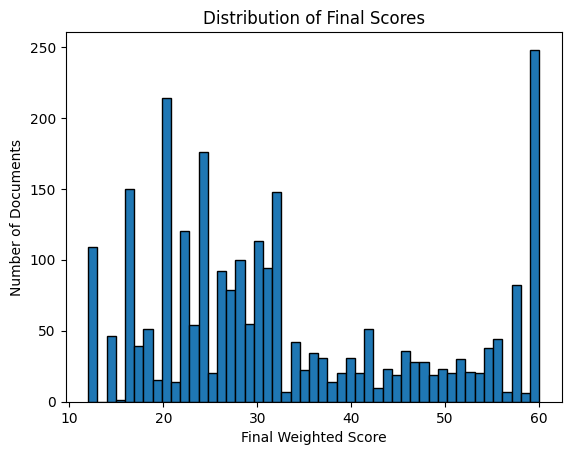

In [25]:
import json
import pandas as pd
import matplotlib.pyplot as plt

relevanceW = 4
completenessW = 1
readabilityW = 2
technicalLevelW = 0
pythonUsabilityW = 5

ratings_filename = "../data/ExtractedDocuments/Exploratory/RelevanceMeasurement/Mistral7B_Ratings_Final.json"
with open(ratings_filename) as ratings_file:
    ratings = json.load(ratings_file)

final_scores = {}
for rating in ratings:
    final_score = (
        rating["relevance"] * relevanceW +
        rating["completeness"] * completenessW +
        rating["readability"] * readabilityW +
        rating["technicallevel"] * technicalLevelW +
        rating["pythonusability"] * pythonUsabilityW
    )
    final_scores[rating["url"]] = final_score
score_values = list(final_scores.values())
min_val = min(score_values)
max_val = max(score_values)
range = max_val - min_val + 1

plt.hist(score_values, bins=range, edgecolor='black')
plt.xlabel("Final Weighted Score")
plt.ylabel("Number of Documents")
plt.title("Distribution of Final Scores")
plt.show()


It seems that we have many documents with perfect scores for the relevant dimensions. We will definitely keep those, but how do we decide how many documents should we keep or how to define a score threshold. 

One way to do this is through the Gaussian Mixture Model (GMM), a model that assumes data is generated from a mixture of Gaussian distributions. This is a useful model to identify clusters within our scores. As we would only have two clusters (included documents and removed documents), we can identify a threshold by obtaining the middle between both clusters' means:

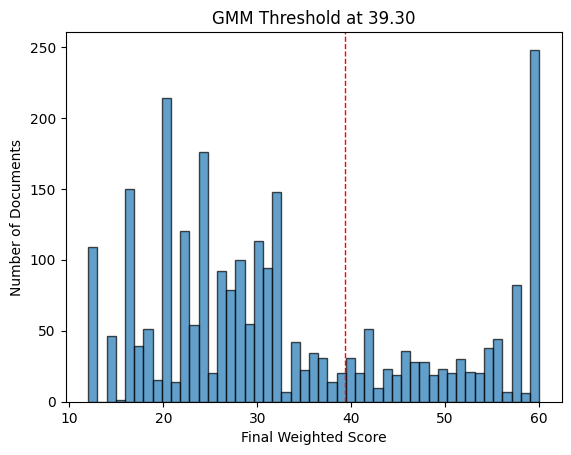

Threshold determined by GMM: 39.30


In [26]:
from sklearn.mixture import GaussianMixture
import numpy as np

score_values = np.reshape(score_values, (-1, 1))
gmm = GaussianMixture(n_components=2, random_state=0).fit(score_values)
gmm_labels = gmm.predict(score_values)
gmm_means = gmm.means_
threshold_gmm = np.mean(gmm_means)

plt.hist(score_values, bins=range, edgecolor='black', alpha=0.7)
plt.axvline(threshold_gmm, color='red', linestyle='dashed', linewidth=1)
plt.xlabel("Final Weighted Score")
plt.ylabel("Number of Documents")
plt.title(f"GMM Threshold at {threshold_gmm:.2f}")
plt.show()

print(f"Threshold determined by GMM: {threshold_gmm:.2f}")


It seems like our threshold given by GMM is 39.3. Scores are integers in our system, so those documents with a score of 40 or higher will be kept and any others will be removed. It does seem worrying that so many documents are going to be ignored based on this threshold; but it does seem relevant by looking at some of them.


Now that we know which documents we will keep, let's move on to the last objective of this notebook: defining what is the best value for `max_depth` for the `RecursiveUrlLoader` based on the document relevance for documents extracted in each iteration. throughout the code below, it is clear that a `max_depth` of `7` (the maximum depth tested) is worthy, as more than `170` relevant articles were extracted here in comparison to a max depth of `5`. This final set of documents will be stored in the file `knowledge_base.json` in `data/ExtractedDocuments/Final`.

In [43]:
from  langchain.schema import Document
import json
from glob import glob
import typing as t
import jsonlines

summary_files = glob("extraction_results_summary.json")
summary_data = []
for file in summary_files:
    with open(file, "r") as f:
        summary_data.extend(json.load(f))

def load_docs_from_jsonl(file_path) -> t.Iterable[Document]:
    documents = []
    with jsonlines.open(file_path, mode="r") as reader:
        for doc in reader:
            documents.append(Document(**doc))
    return documents

for set in summary_data:
    if set["max_depth"] == 1:
        continue
    if set["timeout"] != 2:
        continue
    docs = load_docs_from_jsonl(set["file"])
    filtered_docs = list(filter(lambda d:
                                "Namespace Reference" not in d.metadata["title"] and
                                "Device layer" not in d.metadata["title"] and
                                "Bibliography" not in d.metadata["title"] and
                                "https://docs.opencv.org/4.x/opencv.tag" not in d.metadata["source"] and
                                "Member List" not in d.metadata["title"] and
                                "404 Not Found" not in d.metadata["title"] and
                                "Directory Reference" not in d.metadata["title"],
                                docs))
    final_docs =[]
    for doc in filtered_docs:
        source = doc.metadata["source"]
        if source in final_scores and final_scores[source] > threshold_gmm:
            final_docs.append(doc)
    print(f"Depth: {set["max_depth"]}, initial documents: {len(filtered_docs)}, final documents: {len(final_docs)}")
    if set["max_depth"] == 7:
        filename = "../data/ExtractedDocuments/Final/knowledge_base.json"
        with open(filename, "w") as file:
            for doc in final_docs:
                file.write(doc.json()+'\n')

Depth: 2, initial documents: 79, final documents: 53
Depth: 3, initial documents: 1505, final documents: 323
Depth: 5, initial documents: 1549, final documents: 630
Depth: 7, initial documents: 2664, final documents: 804


With that, we wrap up this exploratory notebook, resulting in a knowledge base of 804 documents generated by using Langchain's `RecursiveUrlLoader`. A few  steps to consider in the future:

- Expand the knowledge base by extracting other OpenCV-related documents. This, however, requires ethical web scraping, and I would be particullary cautious of obtaining express consent to do this when obtaining information from other creators.
- Keep increasing the value of the `max_depth` parameter in `RecursiveUrlLoader` when webscraping OpenCV's documentation. Theoretically, there are some valuable documents out there that haven't been extracted yet. This, however, requires a lengthy process, as each increase in depth level exponentially increases the extraction time.